<a href="https://colab.research.google.com/github/chlolv/NLP_Project/blob/main/Baseline%20-%20Random%20Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package and definitions


In [105]:
# BERT
# bi LSTM
# Hierarchical cross-entropy ?
# Bonne matrice de confusion

import requests as req
import pandas as pd
import os
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
try :
  import transformers
except :
  !pip install transformers
  import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from itertools import compress
import seaborn as sns
from tqdm import *
import time

# torch.cuda.is_available() returns a boolean to check if the GPU can be used or not
if torch.cuda.is_available():
  # if CUDA is available set 'cuda' as the device
  device = 'cuda'
  # and then print the name of the GPU
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  # else, set 'cpu' as device
  device = 'cpu'
  # just print than the CPU is used. Alternatively you can check your CPU with the following command (linux based) in the next cell:
  # ! lscpu
  print('DEVICE = ', colored('CPU', "blue"))

git_url = "https://raw.githubusercontent.com/chlolv/NLP_Project/main/Data/"
H_url = "H_series.csv"
book_url = "book_labels.csv"

# temp fixes due to csv use
H = req.get(git_url + H_url)
H = re.sub('\n\d{0,9}[0-9],',
           '\n', H.text[7:])
words = ["He-", "\\\\", '"', '"', "o-"]
H = re.sub("".join(words), "He-Who", H)
H = re.sub("\*", "" , H)
H = H.split('\n')

book = req.get(git_url + book_url)
book_label_list = re.sub('','0', book.text[6:])
book_label_list = re.sub('010','1', book_label_list)
book_label_list = re.sub('020','2', book_label_list)
book_label_list = re.sub('030','3', book_label_list)
book_label_list = re.sub('040','4', book_label_list)
book_label_list = re.sub('050','5', book_label_list)
book_label_list = re.sub('060','6', book_label_list)
book_label_list = re.sub('070','7', book_label_list)
book_label_list = book_label_list.split('\n')

book_label_list = [int(book) for book in book_label_list]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
DEVICE =  Tesla T4


# Tache de classification des paragraphes

We want our algorithm to predict what characters are in each paragraph. 

In [112]:
# On se rammène à une tâche de classification
character_list = {1: ['Harry', 'Potter'], 2: ['Ron', 'Weasley'], 3: ['Hermione', 'Granger'], 4: ['Snape', 'Severus'], 
                  5:['Albus', 'Dumbledore'], 6: ['Dursley', 'Vernon', 'Dudley', 'Petunia'], 7: ['Draco', 'Malfoy']}
paragraph_character_labels = []
para_id = 0
for paragraph in tqdm_notebook(H) :
  paragraph_character_labels.append('')
  for key in character_list.keys() :
    character = character_list[key]
    if any(name in paragraph for name in character) :
      if paragraph_character_labels[para_id] != '' :
        paragraph_character_labels[para_id] += '_'
      paragraph_character_labels[para_id] += character[0]
  if paragraph_character_labels[para_id] == '' :
    paragraph_character_labels[para_id] += 'None'
  para_id += 1
pd.DataFrame.from_dict(Counter(paragraph_character_labels), orient = 'index').sort_values(by = [0], ascending = [False])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20931 [00:00<?, ?it/s]

,0
Harry,5214
None,3759
Harry_Ron,1758
Harry_Ron_Hermione,1438
Ron,1159
...,...
Ron_Albus_Draco,2
Ron_Hermione_Snape_Draco,2
Ron_Dursley_Draco,1
Harry_Ron_Hermione_Albus_Dursley,1


In [ ]:
# On masque les noms propres 
special_data = []
for paragraph in tqdm_notebook(H) :
  tokenized = nltk.word_tokenize(paragraph)
  proper_nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if pos in ['NNP', 'NNPS']] 
  for proper_noun in proper_nouns :
      paragraph = re.sub(proper_noun, 'charoffocus', paragraph)
      paragraph = re.sub('charoffocus charoffocus', 'charoffocus', paragraph)
      paragraph = re.sub('charoffocus charoffocus', 'charoffocus', paragraph)
      paragraph = re.sub('charoffocus charoffocus', 'charoffocus', paragraph)
  special_data.append(paragraph)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/20931 [00:00<?, ?it/s]

In [108]:
textfile = open("special_data.txt", "w")
for element in special_data:
    textfile.write(element + "\n")
textfile.close()

In [109]:
torch.cuda.empty_cache()

In [110]:
seed = 42
stratify_labels = []
labels = paragraph_character_labels

counted_data = pd.DataFrame.from_dict(Counter(paragraph_character_labels), orient = 'index').sort_values(by = [0], ascending = [False])
data_that_matters = counted_data.index[(counted_data[0] > 500) & (counted_data.index != 'None')]

# On rajoute le livre au label et on met en Other les catégories trop petites
for i in range(0, len(labels)) :
  if labels[i] in data_that_matters :
    new_label = labels[i] + '_' + str(book_label_list[i])
  else :
    new_label = 'Other' + '_' + str(book_label_list[i])
  stratify_labels.append(new_label)

liste_unique_labels = np.unique(stratify_labels)
correspondance_label_numeric = list(range(0, len(np.unique(stratify_labels))))
numeric_stratify_labels = pd.DataFrame(stratify_labels).replace(liste_unique_labels, correspondance_label_numeric)
numeric_stratify_labels = list(numeric_stratify_labels[0])


In [111]:
train_text, test_text, train_labels, test_labels = train_test_split(special_data, numeric_stratify_labels, 
                                                                    random_state = seed, 
                                                                    test_size = 0.3, 
                                                                    stratify = numeric_stratify_labels)

In [11]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
new_tokens = ['charoffocus']
num_added_toks = tokenizer.add_tokens(new_tokens)

max_seq_len = 100

tokens_train = tokenizer.batch_encode_plus(
    train_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(tokens_train['input_ids'], train_labels)

predict = clf.predict(tokens_test['input_ids'])


RandomForestClassifier(max_depth=2, random_state=0)

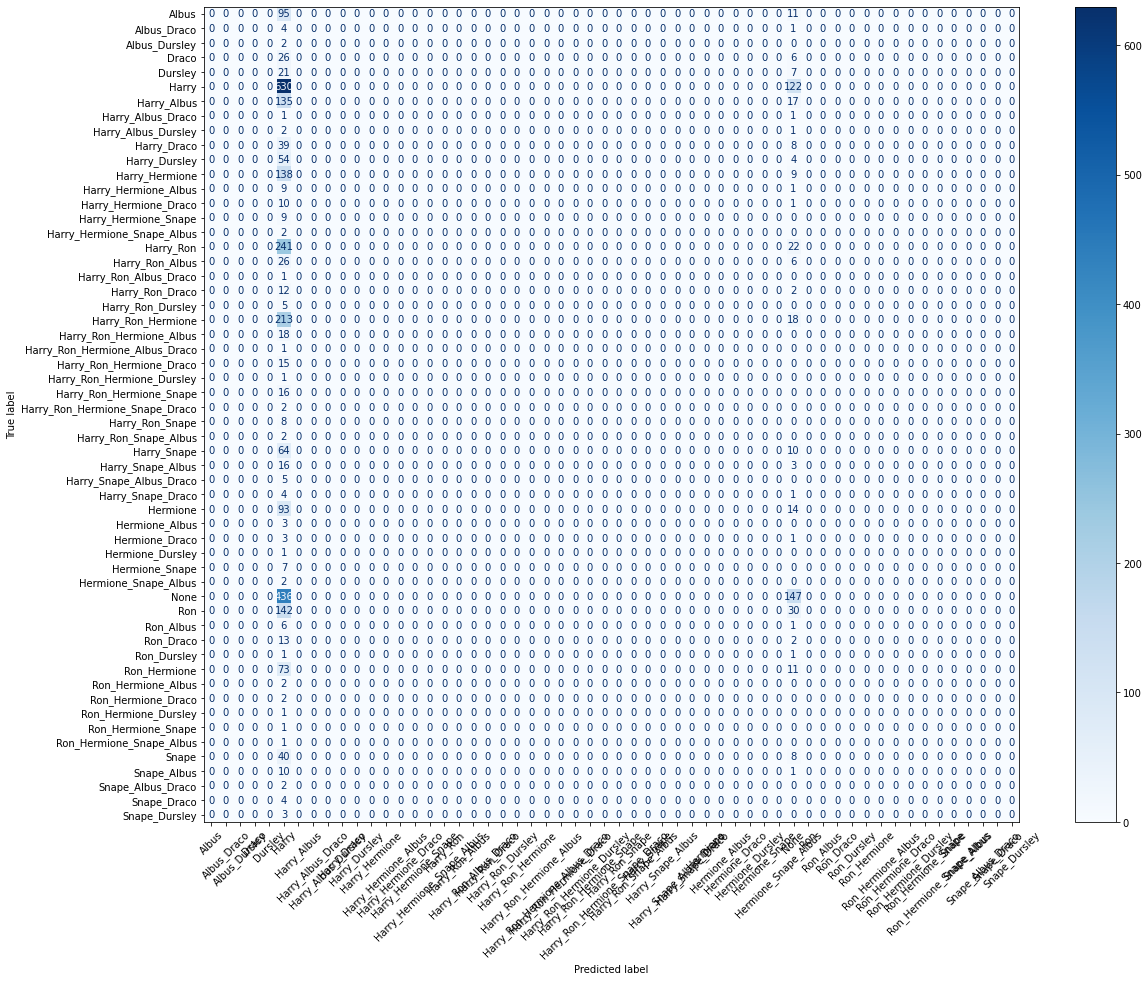

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# model's performance
plt.rcParams['figure.figsize'] = [20, 15]
cm = confusion_matrix(test_labels, predict) 

cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(cmap=plt.cm.Blues, xticks_rotation=45)

